# Motivation

**What data are we working with?**

The domain this project explores is different posts on Reddit found on the subreddit 'Change My View', or r/CMV, where users regularly post controversial questions and discussions in the community.


**What is the goal of this work?**

The goal of this project is visualize the distribution of people's emotions and their reactions to posts of different types. We expect their comments' emotions to follow suit relative to the emotions of the post topic, but this is to be explored.

**How is this achieved?**

This is achieved by leveraging the RoBERTa base Go Emotions model found on HuggingFace. This sentiment analysis pipeline is used to get emotions for a given text input, and ranks them by most likely probability (see code for examples). The Go Emotions dataset is comprised of 28 unqiue emotions and was trained on Reddit data, making it and the respective model an ideal candidate for this project's goals.


**Where can I learn more about this project?**

Find the RoBERTa Go Emotions model [link here](https://huggingface.co/SamLowe/roberta-base-go_emotions) (from HuggingFace)

Find the Go Emotions dataset [link here](https://huggingface.co/datasets/go_emotions) (from HuggingFace)



# Install Dependencies

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline

# Reddit: r/CMV example

**Post title:** 'CMV: It's normal and healthy to still love your ex, even while in a new relationship.'

**Post desc:** 'By the definition of my CMV, I'm ruling out any cases where the "love" borders more on obsession, or where the love gets in the way of the new relationship. This is really a push back against the idea that someone being in contact with their ex is a "red flag". In fact, I believe that still being in contact with an ex can actually be a green flag and can be indicative of a characteristic maturity that allows two adults, who used to be in a relationship, to still be friendly, despite how the relationship may have ended.

It's also important that I make the distinction between love and *in* love. If you're in love with one person, you should not be dating and telling another person you're in love with them - I think this is moving forward with a relationship when you're not emotionally available, and I think that can be incredibly damaging to the new partner. However, loving someone is very different - if you dated someone for years, or maybe even just months, and you developed a strong care for them and their well being, that won't just go away when you stop dating (except in certain more extreme circumstances).

Someone should be able to love their past partner in the sense that they care about them, they remain in contact to see how they're doing and they have a continuing relationship, even while pursuing serious relationships with others.

I'm curious what others think about this.'

**Top Comment 1:** 'If you love someone while you started a new relationship...you weren't ready for that new relationship.'

**Top Comment 2:** 'It's important to consider **why** they are your ex.

If you were dumped, then trying to keep in touch means you haven't moved on and it's a red flag.

If dumped them, it means you are stringing ex along and are being manipulative and it's a red flag.'

**Top Comment 3:** 'I agree with what you're trying to say but the title should have been caring not loving.¬†


You know what the correct word choice is based on your explanation, you know what the possibile connotations are, you've recognized that love is easy to confuse with in love given the context yet you still went with love instead of care...why?'

In [12]:
cmv_df = pd.read_csv('cmv_clean.csv')
# Max emotions represents the total emotions generated for each comment (ie our max)
# Min emotions represents the minimum number of emotions we accept for each comment (threshold)
max_emotions = 6
min_emotions = 3
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=max_emotions)

test_comment_1 = cmv_df.iloc[0]['Comment 1']
test_comment_2 = cmv_df.iloc[0]['Comment 2']
test_comment_3 = cmv_df.iloc[0]['Comment 3']

sentences = [test_comment_1, test_comment_2, test_comment_3]

print("Initial 3 Test Comments")
print("")
count = 1
for sentence in sentences:
  print(f"Comment {count}: {sentence}")
  count += 1

print("")
print("Initial 3 labels")
print("")
for sentence in sentences:
  output = classifier(sentence)
  print(output)

print("")
print("Filtered 3 labels")
print("")

# Builds a list of labels to filter out (if we choose to)
labels_to_exclude = ['neutral']

for sentence in sentences:
    output = classifier(sentence)
    filtered_labels = []
    num_labels = 0

    # Check predictions and filter out labels that are found in the labels_to_exclude
    for prediction in output:
        filtered_predictions = [label for label in prediction if label['label'] not in labels_to_exclude]
        # Check to see if we still need to add more emotions to reach the minimum threshold for classification
        if (num_labels < min_emotions):
          # If we have not reached the min threshold, keep adding emotions
          filtered_labels.append(filtered_predictions)
          num_labels += 1

    print(filtered_labels)

Initial 3 Test Comments

Comment 1: If you love someone while you started a new relationship...you weren't ready for that new relationship.
Comment 2: It's important to consider **why** they are your ex.

If you were dumped, then trying to keep in touch means you haven't moved on and it's a red flag.

If dumped them, it means you are stringing ex along and are being manipulative and it's a red flag.
Comment 3: I agree with what you're trying to say but the title should have been caring not loving. 


You know what the correct word choice is based on your explanation, you know what the possibile connotations are, you've recognized that love is easy to confuse with in love given the context yet you still went with love instead of care...why?

Initial 3 labels

[[{'label': 'neutral', 'score': 0.8108245730400085}, {'label': 'disapproval', 'score': 0.07914366573095322}, {'label': 'realization', 'score': 0.042752474546432495}, {'label': 'disappointment', 'score': 0.021041031926870346}, {'lab

# Aggregating Overall Comment Emotions

In [3]:
import pandas as pd
from transformers import pipeline

cmv_df = pd.read_csv('cmv_clean.csv')

# Initialize the text classification pipeline found from this link below:
# https://huggingface.co/SamLowe/roberta-base-go_emotions
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

# Create a new map to store emotion frequencies
emotion_frequency = {}

# Initialize counter and total_count to keep track of progress while progressing through batches
counter = 0
total_count = len(cmv_df)

for index, row in cmv_df.iterrows():
    batch_comments = []

    # Collect comments for batch processing
    for i in range(1, 6):
        comment = row[f'Comment {i}']
        # Ensure comment is not NaN and less than the max tokens necessitated by model
        if isinstance(comment, str) and len(comment) < 512:
            batch_comments.append(comment)

    # Process comments in batches
    if len(batch_comments) > 0:
        outputs = classifier(batch_comments)

        for output in outputs:
            # Grab emotion labels for each output
            emotion_labels = [label['label'] for label in output]
            for emotion_label in emotion_labels:
              # Initialize the emotion to have frequency 1 if not found
              if emotion_label not in emotion_frequency:
                  emotion_frequency[emotion_label] = 1
              else:
                  # Otherwise increase the current value
                  emotion_frequency[emotion_label] += 1

    # Print out progress every 200 batches
    if (counter > 0 and counter % 200 == 0):
        print(f"Current count is: {counter} / {total_count}")
        print("Emotion Frequencies:")
        for emotion, count in emotion_frequency.items():
            print(f"{emotion}: {count}")
        print("")

    counter += 1

# Print the final resulting emotion frequencies
print("Final Emotion Frequencies:")
for emotion, count in emotion_frequency.items():
    print(f"{emotion}: {count}")


Current count is: 200 / 844
Emotion Frequencies:
neutral: 480
disapproval: 299
realization: 233
disappointment: 99
approval: 362
annoyance: 301
curiosity: 192
love: 9
confusion: 223
anger: 33
disgust: 11
amusement: 13
embarrassment: 2
optimism: 61
admiration: 26
excitement: 6
sadness: 31
joy: 10
surprise: 13
desire: 9
remorse: 4
fear: 6
nervousness: 2
caring: 13
relief: 2

Current count is: 400 / 844
Emotion Frequencies:
neutral: 937
disapproval: 570
realization: 443
disappointment: 186
approval: 711
annoyance: 586
curiosity: 374
love: 12
confusion: 429
anger: 70
disgust: 19
amusement: 22
embarrassment: 2
optimism: 130
admiration: 81
excitement: 12
sadness: 52
joy: 21
surprise: 20
desire: 16
remorse: 6
fear: 18
nervousness: 7
caring: 33
relief: 2
pride: 1
gratitude: 4
grief: 1

Current count is: 600 / 844
Emotion Frequencies:
neutral: 1423
disapproval: 854
realization: 669
disappointment: 265
approval: 1091
annoyance: 884
curiosity: 594
love: 16
confusion: 681
anger: 92
disgust: 30
amu

# Visualize Emotions of all Comments on r/CMV

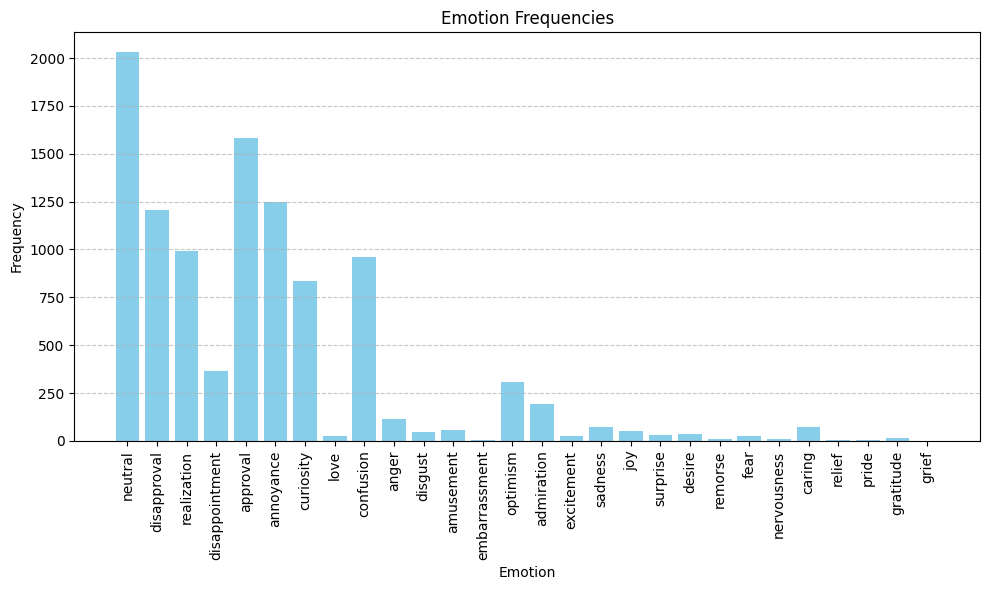

In [4]:
import matplotlib.pyplot as plt

# Extract emotion labels and corresponding frequencies from our final list
emotions = list(emotion_frequency.keys())
frequencies = list(emotion_frequency.values())

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(emotions, frequencies, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Frequencies')
# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Adjust layout to prevent label clips
plt.tight_layout()
plt.show()

# Emotions Analysis:

**Neutral Emotion Possibly Overrepresented**
Because understanding the complexity of these responses can be difficult, this is likely the reason that the 'neutral' emotion has such high frequency, and is possibly overrepresented given the actual range of emotions on r/CMV.

**Approval / Disapproval Emotions Common**
Due to the nature of binary discourse on r/CMV, people are generally either for or against a controversial discussion topic, and sometimes will even explicitly state 'I agree' or 'I disagree' in their comment.

**Logical Reasoning and Realization** On r/CMV, it is common to explain and think through the logic of an argument or perspective on a topic. This likely leads to the 'realization' emotion being significantly higher than the other emotions not mentioned above (ie compared to joy, surprise, relief, etc.).

# Aggregating Emotions based on Post Sentiment

Post Sentiment is one of the following options {Positive/Neutral/Negative}

In [5]:

# Initialize the text classification pipeline for emotion analysis (Go emotions from Hugging Face)
# (see link above)
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=5)

cmv_df = pd.read_csv('cmv_clean.csv')

# Define the mapping of emotions to sentiment categories
# From Go Emotions dataset (see link above)
emotion_sentiment_mapping = {
    'joy': 'positive',
    'optimism': 'positive',
    'amusement': 'positive',
    'love': 'positive',
    'excitement': 'positive',
    'admiration': 'positive',
    'relief': 'positive',
    'gratitude': 'positive',
    'pride': 'positive',
    'caring': 'positive',
    'approval': 'positive',
    'neutral': 'neutral',
    'surprise': 'neutral',
    'realization': 'neutral',
    'confusion': 'neutral',
    'curiosity': 'neutral',
    'disapproval': 'negative',
    'desire': 'negative',
    'remorse': 'negative',
    'disappointment': 'negative',
    'annoyance': 'negative',
    'nervousness': 'negative',
    'anger': 'negative',
    'fear': 'negative',
    'embarassment': 'negative',
    'sadness': 'negative',
    'grief': 'negative',
    'disgust': 'negative',
    'annoyance': 'negative'
}

# Initialize count var for batch logging progress
count = 0

# Create a dictionary to store sentiment frequencies
sentiment_frequency = {'positive': 0, 'negative': 0, 'neutral': 0}

# Create a dictionary to store emotion frequencies for each sentiment category
emotion_frequency = {'positive': {}, 'negative': {}, 'neutral': {}}

# Iterate over each row in the DataFrame
for index, row in cmv_df.iterrows():
    # Log Progress every 200 batches
    if (count > 0 and count % 200 == 0):
        print(f"COUNT: {count}")
        print(sentiment_frequency)
        print(emotion_frequency)
        print("")

    # Process the post body for sentiment analysis ()
    post_body = str(row['Body'])

    # Truncate post_body if it exceeds 512 characters
    post_body = post_body[:512]

    if post_body:
        # Analyze emotions of the post body
        emotions = classifier(post_body)

        # Make sure we have emotions for the post
        if emotions and len(emotions) > 0:
            # Grab the top emotion for the post body
            top_emotion_post = emotions[0][0]['label']
            if top_emotion_post in emotion_sentiment_mapping:
                # Convert that top emotion into a sentiment (positive/neutral/negative)
                # for later analysis
                post_sentiment = emotion_sentiment_mapping[top_emotion_post]

                # Update sentiment frequency of posts
                sentiment_frequency[post_sentiment] += 1

        # Create our batch comments
        batch_comments = []
        for i in range(1, 6):
            comment_key = f'Comment {i}'
            # Truncate comments to first 512 characters
            row[comment_key] = str(row[comment_key])[:512]
            if isinstance(row[comment_key], str):
                batch_comments.append(row[comment_key])

        # Process the comments for emotion analysis (using top 5 comments)
        if batch_comments:
            for comment in batch_comments:
                # Grab the emotion with the highest probability rating
                top_emotion_comment = classifier(comment)[0][0]['label']
                if top_emotion_comment not in emotion_frequency[post_sentiment]:
                    # If the emotion does not exist, set freq to be 1 for the emotion
                    emotion_frequency[post_sentiment][top_emotion_comment] = 1
                else:
                    # Otherwise increment the current count for the emotion
                    emotion_frequency[post_sentiment][top_emotion_comment] += 1

        # increment our overall count that does batch logging
        count += 1


print(f"Total number of Reddit posts evaluated: {len(cmv_df)}");
print("")

print("Final Post Sentiment Distribution")
print(sentiment_frequency)
print("")

print("Final Comment Emotion Distribution for Posts")
print(emotion_frequency)
print("")

COUNT: 200
{'positive': 33, 'negative': 25, 'neutral': 142}
{'positive': {'neutral': 93, 'curiosity': 21, 'disapproval': 11, 'confusion': 8, 'love': 3, 'remorse': 2, 'approval': 13, 'annoyance': 8, 'amusement': 3, 'gratitude': 1, 'realization': 1, 'anger': 1}, 'negative': {'neutral': 78, 'approval': 5, 'confusion': 6, 'disappointment': 2, 'amusement': 3, 'curiosity': 10, 'disapproval': 8, 'remorse': 1, 'joy': 1, 'anger': 1, 'desire': 1, 'caring': 2, 'sadness': 2, 'annoyance': 5}, 'neutral': {'neutral': 458, 'approval': 44, 'confusion': 40, 'curiosity': 66, 'annoyance': 12, 'amusement': 8, 'love': 5, 'disapproval': 43, 'admiration': 3, 'surprise': 5, 'nervousness': 1, 'optimism': 3, 'realization': 4, 'disappointment': 6, 'caring': 3, 'disgust': 2, 'anger': 1, 'remorse': 2, 'gratitude': 1, 'joy': 1, 'sadness': 1, 'embarrassment': 1}}

COUNT: 400
{'positive': 67, 'negative': 58, 'neutral': 275}
{'positive': {'neutral': 185, 'curiosity': 37, 'disapproval': 19, 'confusion': 17, 'love': 4, '

# Overall Post Sentiment Distribution

Positive / Neutral / Negative

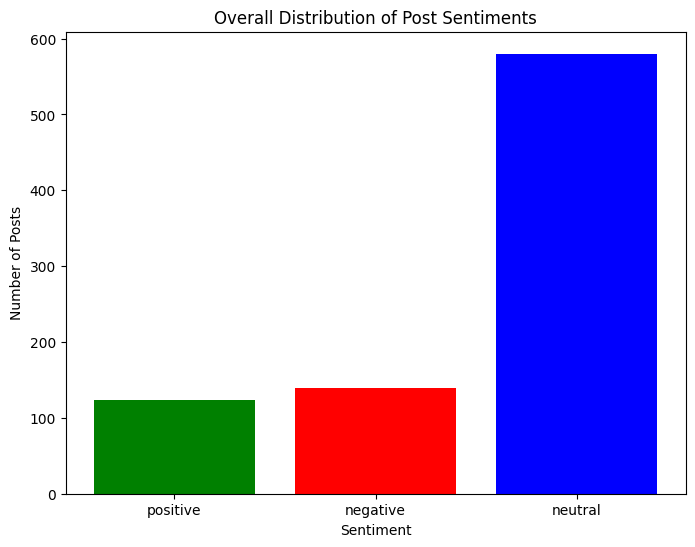

In [13]:
# Data for the overall distribution of post sentiments
sentiments = list(sentiment_frequency.keys())
counts = list(sentiment_frequency.values())

# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiments, counts, color=['green', 'red', 'blue'])
plt.title('Overall Distribution of Post Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.show()


# Respective Emotion Distribution for Post Sentiment

28 Unique Emotions (Go Emotions) - See Motivation Above

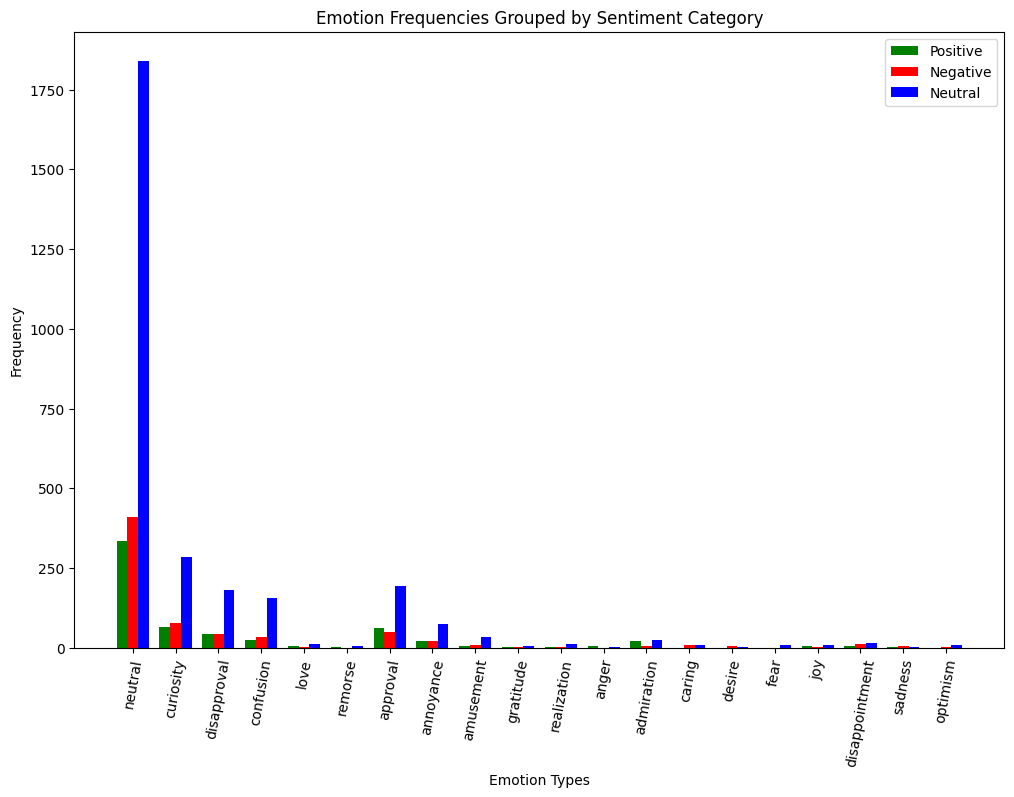

In [14]:
# Data for emotion frequencies across different sentiment categories
sentiments = list(emotion_frequency.keys())
emotion_types = list(emotion_frequency['positive'].keys())
num_emotions = len(emotion_types)

# Prepare data for the grouped bar chart
positive_emotions = [emotion_frequency['positive'].get(emotion, 0) for emotion in emotion_types]
negative_emotions = [emotion_frequency['negative'].get(emotion, 0) for emotion in emotion_types]
neutral_emotions = [emotion_frequency['neutral'].get(emotion, 0) for emotion in emotion_types]

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Set width of bars
bar_width = 0.25
index = np.arange(num_emotions)

# Plotting the grouped bar chart
bar1 = ax.bar(index - bar_width, positive_emotions, bar_width, label='Positive', color='green')
bar2 = ax.bar(index, negative_emotions, bar_width, label='Negative', color='red')
bar3 = ax.bar(index + bar_width, neutral_emotions, bar_width, label='Neutral', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Emotion Types')
ax.set_ylabel('Frequency')
ax.set_title('Emotion Frequencies Grouped by Sentiment Category')
ax.set_xticks(index)
ax.set_xticklabels(emotion_types, rotation=80)

# Add a legend for sentiment categories
ax.legend(['Positive', 'Negative', 'Neutral'])

# Show the plot
plt.show()
